# DeepSurv

In this notebook we will train the [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf), also known as [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1).

In [1]:
!pip install torchtuples
!pip install pycox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 608.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 412.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.4 MB/s eta 0:00:00
  Created wheel for feather-format: filename=feather_format-0.4.1-py3-none-any.whl size=2436 sha256=c13974f8bbc2b1e2b5d2724fba38ee1a99bc8b65e1da21b842bc592be9c089d1
  Stored in directory: /root/.cache/pip/wheels/a6/ff/5d/4f10de26fe5d

In [2]:
# downgrade of pandas is needed too use "is_monotonic" in the package
!pip install pandas==1.4.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 7.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.2.0 requires pandas>=1.5.0, but you have pandas 1.4.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.4.4 which is incompatible.
plotnine 0.12.4 requires pandas>=1.5.0, but you have pandas 1.4.4 which is incompatible.


In [3]:
pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 10.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=0dbe8fb9556c4a4e9aff31c4fd765614d2b48405d36b392e8cbf6f20a6bec98b
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

from sklearn.model_selection import ParameterSampler

from lifelines import KaplanMeierFitter

In [5]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## 1. Dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Read the preprocessed file
brca = pd.read_csv('/content/drive/My Drive/3799_new/brca.csv')

## 2. Modelling

### Train, valid, and test set split

In [8]:
data = brca

In [9]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train, validation, and test sets while maintaining class balance
df_train_val, df_test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['status'])
df_train, df_val = train_test_split(df_train_val, test_size=0.2, random_state=42, stratify=df_train_val['status'])

### Feature transforms
All variables needs to be of type `'float32'`, as this is required by pytorch.

In [10]:
from sklearn_pandas import DataFrameMapper
# Get a list of all column names in the DataFrame
all_cols = data.iloc[:,2:].columns.tolist()

# Create a list of tuples for all columns
all_cols_tuples = [(col, None) for col in all_cols]

# Create the DataFrameMapper object with all columns
x_mapper = DataFrameMapper(all_cols_tuples)

In [11]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [12]:
# Extract target
get_target = lambda df: (df['time'].values, df['status'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
y_test = get_target(df_test)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

### Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout.
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [31]:
from sklearn.base import BaseEstimator

class DeepSURVSklearnAdapter(BaseEstimator):
    def __init__(
        self,
        learning_rate=1e-4,
        batch_norm=True,
        dropout=0.0,
        num_nodes=[32, 32],
        batch_size=128,
        epochs=10,
    ):
        self.learning_rate = learning_rate
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.num_nodes = num_nodes
        self.batch_size = batch_size
        self.epochs = epochs

    def fit(self, X, y):
        self.net_ = tt.practical.MLPVanilla(
            X.shape[1],
            self.num_nodes,
            1,
            self.batch_norm,
            self.dropout,
            output_bias = False, # prevent overfitting/simplify the model
        )
        self.deepsurv_ = CoxPH(self.net_, tt.optim.Adam)
        self.deepsurv_.optimizer.set_lr(self.learning_rate)

        # Sklearn needs the y inputs to be arranged as a matrix with each row
        # corresponding to an example but CoxPH needs a tuple with two arrays?
        y_ = (y[0], y[1])

        #callbacks = [tt.callbacks.EarlyStopping()]
        #callbacks = [tt.callbacks.EarlyStopping(patience=5)]
        callbacks = [tt.callbacks.EarlyStopping(patience=10)]

        log = self.deepsurv_.fit(
            X,
            y_,
            self.batch_size,
            self.epochs,
            #callbacks = callbacks,
            verbose=False
        )

        return self

    def score(self, X, y):
        _ = self.deepsurv_.compute_baseline_hazards()
        surv = self.deepsurv_.predict_surv_df(X)

        ev = EvalSurv(
            surv,
            y[0],  # time to event
            y[1],  # event
            censor_surv="km",
        )

        return ev.concordance_td()

    def brier_score(self, X, y, time_grid):
        _ = self.deepsurv_.compute_baseline_hazards()
        surv = self.deepsurv_.predict_surv_df(X)

        ev = EvalSurv(
            surv,
            y[0],  # time to event
            y[1],  # event
            censor_surv="km",
        )

        return ev.brier_score(time_grid)

    def integrated_brier_score(self, X, y, time_grid):
        _ = self.deepsurv_.compute_baseline_hazards()
        surv = self.deepsurv_.predict_surv_df(X)

        ev = EvalSurv(
            surv,
            y[0],  # time to event
            y[1],  # event
            censor_surv="km",
        )

        return ev.integrated_brier_score(time_grid)

    def predict(self, X):
        _ = self.deepsurv_.compute_baseline_hazards()
        # Predict survival probabilities for X
        return self.deepsurv_.predict_surv_df(X)

    def calc_rmst_pred_error(self, X, y, time_point):
        _ = self.deepsurv_.compute_baseline_hazards()
        surv = self.deepsurv_.predict_surv_df(X)
        surv_prob = surv.reset_index()

        time_list=[]
        for i in surv_prob['duration']:
          if i<=(time_point+1):             # 5-year RMST
              time_list.append(i)

        if time_point not in time_list:
          time_list.append(time_point)

        # Calculate RMST
        rmst_i = pd.DataFrame(columns=surv_prob.columns[1:])
        for i in range(len(time_list)-1):
          t = time_list[i]
          t_plus_1 = time_list[i+1]
          row_num = surv_prob[surv_prob['duration'] == t].index[0]
          s_t = surv_prob.iloc[row_num, 1:]
          mu = (t_plus_1 - t) * s_t

          rmst_i = pd.concat([rmst_i, pd.DataFrame([mu])])

          # len(time_list) = 419, len(rmst_i) = 418

        rmst = pd.DataFrame(rmst_i.sum(axis=0))
        rmst = rmst.rename(columns={0: 'rmst'})

        test = df_test.copy()
        test = test.iloc[:,:2]
        test = test.reset_index(drop=True)
        test = pd.concat([test, rmst], axis=1)
        test = test[test["time"] <= time_point]

        train = df_train.copy()
        train = train.iloc[:,:2]
        train = train.reset_index(drop=True)
        train = train[train["time"] <= time_point]

        # Kaplan-Meier estimator of the censoring distribution
        # fitted to training dataset
        kmf = KaplanMeierFitter()
        kmf.fit(train['time'], 1-train['status'])

        cen = kmf.survival_function_
        cen = cen.reset_index()
        cen = cen[cen["timeline"] <= time_point]

        # Calculate the time intervals col
        cen['interval'] = list(zip(cen['timeline'], cen['timeline'].shift(-1, fill_value=cen['timeline'].iloc[-1])))
        cen.at[cen.index[-1], 'interval'] = (cen['timeline'].iloc[-1], time_point)

        # Search for KM estimates of surv prob in test set
        survival_probabilities = []

        # Iterate over each time point
        for i in test['time']:
            # Find the corresponding interval in the 'interval' column of 'cen'
            for _, interval in cen.iterrows():  # _ to discard the index
                if i >= interval['interval'][0] and i < interval['interval'][1]:
                    # Append the survival probability to the list
                    survival_probabilities.append(interval['KM_estimate'])
                    break

        # Add the list of survival probabilities as a new column to the DataFrame
        test['KM_estimate'] = survival_probabilities

        # convert string-based index to int-based index
        test.reset_index(drop=True, inplace=True)

        up_sum = 0
        low_sum = 0

        for i in range(len(test)):
          # 5-year RMST prediction error
          up = (1/test['KM_estimate'][i])*test["status"][i]*abs(test['time'][i]-test['rmst'][i])
          low = (1/test['KM_estimate'][i])*test["status"][i]
          up_sum+=up
          low_sum+=low

        pred_error=up_sum/low_sum

        return rmst, pred_error

### Hyperparameter tuning

In [15]:
# Define the parameter grid for random search
param_grid = {
    'learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],
    'dropout': [0.0, 0.1, 0.2],
    'num_nodes': [[32, 32], [64, 64], [32, 64]],
    'batch_size': [128, 256, 512],
    'epochs': [512]
}

# Define the number of parameter settings that will be sampled
n_iter = 10

# Perform random search
random_search = ParameterSampler(param_grid, n_iter=n_iter, random_state=123)

best_score = float('-inf')
best_params = None

for params in random_search:
    print("Current parameters:", params)
    model = DeepSURVSklearnAdapter(**params)
    model.fit(x_train, y_train)
    c_index = model.score(x_val, y_val)
    print("C-index:", round(c_index,3))
    if c_index > best_score:
        best_score = c_index
        best_params = params
    print("=" * 40)

print("Best parameters:", best_params)
print("Best C-index:", round(best_score,3))

Current parameters: {'num_nodes': [32, 32], 'learning_rate': 0.1, 'epochs': 512, 'dropout': 0.1, 'batch_size': 512}
C-index: 0.707
Current parameters: {'num_nodes': [64, 64], 'learning_rate': 0.01, 'epochs': 512, 'dropout': 0.2, 'batch_size': 512}
C-index: 0.682
Current parameters: {'num_nodes': [32, 32], 'learning_rate': 0.01, 'epochs': 512, 'dropout': 0.1, 'batch_size': 512}
C-index: 0.685
Current parameters: {'num_nodes': [32, 32], 'learning_rate': 0.001, 'epochs': 512, 'dropout': 0.0, 'batch_size': 256}
C-index: 0.659
Current parameters: {'num_nodes': [32, 64], 'learning_rate': 0.1, 'epochs': 512, 'dropout': 0.2, 'batch_size': 256}
C-index: 0.687
Current parameters: {'num_nodes': [64, 64], 'learning_rate': 0.001, 'epochs': 512, 'dropout': 0.2, 'batch_size': 128}
C-index: 0.636
Current parameters: {'num_nodes': [64, 64], 'learning_rate': 0.1, 'epochs': 512, 'dropout': 0.1, 'batch_size': 128}
C-index: 0.0
Current parameters: {'num_nodes': [32, 64], 'learning_rate': 0.001, 'epochs': 5

## 3. Evaluation and Prediction

In [16]:
# num_nodes=[32, 32], learning_rate = 0.1, epochs = 512, dropout = 0.1, batch_size = 512

In [17]:
# Initialize lists to store C-index and integrated Brier score
c_index_scores = []
integrated_brier_scores = []
prediction_error = []

# Repeat the process 20 times
for _ in range(20):
    # Create and train the best model with the best parameters
    best_model = DeepSURVSklearnAdapter(**best_params)
    best_model.fit(x_train, y_train)

    # Evaluate the best model on the test data
    # Calculate c-index
    c_index = best_model.score(x_test, y_test)
    c_index_scores.append(c_index)

    # Calculate integrated Brier score
    time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
    integrated_brier = best_model.integrated_brier_score(x_test, y_test, time_grid)
    integrated_brier_scores.append(integrated_brier)

    # Calculate prediction_error for 5-year RMST
    # 5-year: 365.25 * 5 = 1826.25
    # 10-year: 3652.5
    # time_point = 3652.5
    # pred_error = best_model.calc_rmst_pred_error(x_test, y_test, time_point)[1] # 5-year RMST prediction error
    # pred_error = pred_error/365.25 # convert back to year scale
    # prediction_error.append(pred_error)

In [18]:
# Calculate the mean C-index, integrated Brier score, and prediction error
mean_c_index = np.mean(c_index_scores)
mean_integrated_brier = np.mean(integrated_brier_scores)
# mean_pred_error = np.mean(prediction_error)

print("Mean C-index:", round(mean_c_index, 3))
print("Mean integrated Brier score:", round(mean_integrated_brier, 3))
# print("Mean prediction error:", round(mean_pred_error, 3))

Mean C-index: 0.777
Mean integrated Brier score: 0.169


In [21]:
# print(prediction_error)

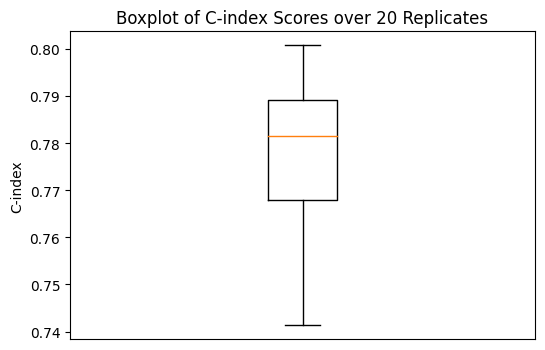

In [22]:
# Plot boxplot of C-index scores over 20 replicates
plt.figure(figsize=(6, 4))
plt.boxplot(c_index_scores)
plt.title('Boxplot of C-index Scores over 20 Replicates')
plt.ylabel('C-index')
plt.xticks([])
plt.show()

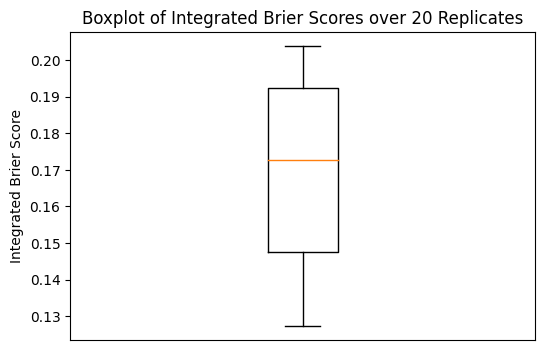

In [23]:
# Plot boxplot of integrated Brier scores
plt.figure(figsize=(6, 4))
plt.boxplot(integrated_brier_scores)
plt.title('Boxplot of Integrated Brier Scores over 20 Replicates')
plt.ylabel('Integrated Brier Score')
plt.xticks([])
plt.show()

In [24]:
# Plot boxplot of prediction_error for 5-year RMST over 20 replicates
#plt.figure(figsize=(6, 4))
#plt.boxplot(prediction_error)
#plt.title('Boxplot of Prediction error for 5-year RMST over 20 Replicates')
#plt.ylabel('Prediction error')
#plt.xticks([])
#plt.show()

In [25]:
# Save the combined data to a text file
with open('deepsurv_scores.txt', 'w') as file:
    file.write("# Deepsurv\n")
    file.write("deepsurv_c_index=")
    file.write(str(c_index_scores) + "\n")
    file.write("deepsurv_ibs=")
    file.write(str(integrated_brier_scores) + "\n")
    #file.write("deepsurv_pe=")
    #file.write(str(prediction_error) + "\n")

# Download the text file
from google.colab import files
files.download('deepsurv_scores.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>